In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from matplotlib.backends.backend_pdf import PdfPages
from itertools import permutations
sns.set()


In [13]:
# Function to imort file or files from a local folder
def import_file(folder_path = "folder_name"):
    for file in os.listdir(folder_path):    
        if file.endswith(".csv"):    
            filepath = os.path.join(folder_path, file)   
    df = pd.read_csv(filepath)
    return df

In [94]:
class HDX(object):
    
    def __init__(self, df, states_list):
        
        """
        The states_list is a list of the states in .csv file from the HDExaminer.
        The current "states_list" will be the default list, but you can change it to any names
        by passing it as an argument in the function where it is needed.
        The df is just the dataframe imported using the above import_file function. It is the
        default dataframe. 
        
        """
            
        self.pep_map = {"WED I": range(1, 1+24), 
               "REC 1": range(25, 1+339),
               "REC 2": range(340, 1+591),
               "WED II": range(592, 1+662),
               "PI": range(663, 1+762),
               "WED III": range(763, 1+892),
               "RuvC I": range(893, 1+953),
               "BH": range(954, 1+971),
               "RuvC II": range(972, 1+1078),
               "Nuc": range(1079, 1+1254),
               "RuvC III": range(1255, 1+1300)}

        
        self.states_list = states_list
        self.df = df

    def rename_states(self):
        
        """
        df = dataframe, states_list is a list of states you want to rename to. 
        You can rename in your own way, but you need to make sure that the number
        of the states in the state_list must match to the unique states in the .csv file.
        It returns the dataframe with the name of states provided. 

        """
        
        states = self.df['Protein State'].unique()
        state_renames ={}

        for st, stls in zip(states, self.states_list):
            state_renames[st] =stls
        self.df['Protein State'].replace(state_renames, inplace=True)

        return df


    def organize(self):

        """
        This functin will organize all the states in the data frame
        so that individual states can be plotted efficiently.
        df = dataframe. The states_list is a list of your preferred names for states
        The number of states in the 'states_list' has to be the same as
        the actual number of the states in the .csv file. 
        It returns a data frame.

        """
        # Updating the df using rename_states function with the default parameters
        #so that the current function can be used independently.
        df = self.rename_states()
        
        # List of states in the csv file.
        states = list(df['Protein State'].unique())
        
        # Now separating states as an individulat dataframe
        frames =[]

        for i in states:
            i = df[df['Protein State']==i]
            frames.append(i)

        # Renaming style which is needed to join the above frames horizontally.
        rnst =[]
        for i in states:
            i = "_"+ i
            rnst.append(i)

        # Combining all dataframes in the frames list
        df = reduce(lambda left,right: pd.merge(left,right,
                                                 on=['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD'],
                                              how='outer', suffixes= tuple(rnst[:-1])), frames)

        colnames = list(df.columns)

        # Renaming the columns of the state so that it matches with the other states
        new_names = [i + "_" + self.states_list[-1] for i in colnames[-8:]]

        maps={}
        for i, j in zip(colnames[-8:], new_names):
            maps[i] =j

        df= df.rename(columns= maps)

        return df

    def pre_process(self):
        """
        This function generate a column with the peptides number,
        its sequence, start and end positions of the peptide. It also
        reindexes by the peptide numbers. It returns a dataframe.
        """
        
        df = self.organize()

        # indexing unique peptides from 1.
        idx = range(1,1+len([i for i in df['Sequence'].unique()]))

        idx_dict = {idx: i for (idx, i) in zip(idx, df['Sequence'].unique())}

        df['idx_pep'] = [idx for idx, pep in idx_dict.items() for p in df['Sequence'] if p == pep]

        # New Column containg the unique index number and the start and end of the sequence

        df['idx']= df['idx_pep'].astype("str") + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # New Column containg the peptides, its unique index number and the start and end of the sequence

        df['peps'] = df['idx_pep'].astype("str").apply(
            lambda x: x + ". "
        ) + df['Sequence'] + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # setting the idx_pep column as the index of the dataframe
        df.index = df['idx']

        df = df.rename({"idx":"idx1"}, axis = 1)
        return df
    
    def state_diff(self):
        """ 
        This function names the column that 
        will be generated from the vectorized operations.
        
        """
        
        stls = list(permutations(self.states_list, 2))
        
        st_li =[]
        
        for i in range(len(stls)):
            
            a = stls[i]
            
            new = a[0]+"_"+a[1]
            
            st_li.append(new)
        
        return st_li
    
    def state_diff_error(self):
        
        """
        This function names the column that 
        will be generated from the vectorized operations,
        
        """
        
        stls = list(permutations(self. states_list, 2))
        
        stls_error = [(i,'std' ) for i in stls]
        
        st_li_er =[]
        
        for i in range(len(stls_error)):
            
            a,b = stls_error[i]
            
            new = a[0]+"_"+a[1]+ "_" + b
            
            st_li_er.append(new)
            
        return st_li_er

    def domains_mapping(self):
        
        """
        The pep_map is a dictionary mapping peptides sequence 
        number to the respective domains name.
        It returns the data frmae with a column name domain
        whose values are mapped domain names of the protein.
        The check argument is just to check if the code runs fine. 
        The default state is False.
        
        """
        df = self.pre_process()
        
        # Creating list of Start numbers from the "Start" Column
        start = list(df.Start)

        # Creating list of End numbers from the "End" Column
        end = list(df.End)

        # Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
        sts = []
        ens = []
        for keys, values in self.pep_map.items():
            for d in values:

                for st in start:
                    if st == d:
                        sts.append(keys)

                for en in end:
                    if en == d:
                        ens.append(keys)


        # Finding the peptides and its indexes that shares multiple domains.
        ov =[]
        ov_idx= []
        for (idx, i), (dx,j) in zip(enumerate(sts),enumerate(ens)):
            if i!=j:
                ov.append((sts[idx],ens[dx]))
                ov_idx.append(idx)

        # now renaming those peptides interms of what overlapping domains they belong to 
        ovl =[]            
        for a, b in ov:
            i = a+" - "+b
            ovl.append(i)

        cts = sts.copy()
        #Finally replacing those overlapping peps names in "sts" list with the new names
        for (dx,j), (x,k )in zip(enumerate(ov_idx), enumerate(ovl)):
            cts[j] = k

        # Creating a new column in the data frame with domain name
        df["domains"] = cts
        df["domains_start"] = sts
        
        # A column with a concatenated peptides' names and their domains'names.
        df["pepsdmn"] = df.peps.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
        df["idxdmn"] = df.idx1.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
                
        return df
    
    def cal_diff(self):
        
        sts_comb = list(permutations(self.states_list, 2))
        
        # Making new columns named i showing the differences among multiple states 
        
        df = self.domains_mapping()
        
        for i, j in zip(self.state_diff(), sts_comb):
            
            df[i] = df["#D_" + j[0]] - df["#D_" + j[1]]
            
        # Making new columns named i for the respective errors using standard error propagation rules    
        
        for i, j in zip(self.state_diff_error(), sts_comb):
                
            df[i] = (df["Stddev_" + j[0]]**2 + df["Stddev_" + j[1]]**2).apply(np.sqrt)
        
        df.to_csv("Processed_HDX_file.csv")
            
        return df

In [95]:
df = import_file(folder_path = "Data")
states_list = ["Apo", "Binary", "Ternary"]
df.head()

,Protein State,Start,End,Sequence,Deut Time (sec),maxD,#D,%D,Conf Interval (#D),#Pts,Confidence,Stddev,p
0,FnCas12a,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,Medium,0.026,NaN
1,FnCas12a,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,Medium,0.012,NaN
2,FnCas12a,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,Medium,0.353,NaN
3,FnCas12a,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,Medium,0.000,NaN
4,FnCas12a,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,Medium,0.406,NaN


In [98]:
hdx = HDX(df , states_list )
hdx.pre_process().head()

,Protein State_Apo,Start,End,Sequence,Deut Time (sec),maxD,#D_Apo,%D_Apo,Conf Interval (#D)_Apo,#Pts_Apo,...,#D_Ternary,%D_Ternary,Conf Interval (#D)_Ternary,#Pts_Ternary,Confidence_Ternary,Stddev_Ternary,p_Ternary,idx_pep,idx1,peps
idx,,,,,,,,,,,,,,,,,,,,,
1 (7-13),Apo,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,...,0.171,3.410,0.387,2.0,Medium,0.043,0.011209,1,1 (7-13),1. FVNKYSL (7-13)
1 (7-13),Apo,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,...,0.794,15.878,0.441,2.0,Medium,0.049,0.026255,1,1 (7-13),1. FVNKYSL (7-13)
1 (7-13),Apo,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,...,0.825,16.491,0.104,2.0,Medium,0.012,0.098001,1,1 (7-13),1. FVNKYSL (7-13)
1 (7-13),Apo,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,...,1.002,20.038,0.805,2.0,Medium,0.090,1.000000,1,1 (7-13),1. FVNKYSL (7-13)
1 (7-13),Apo,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,...,1.017,20.344,0.599,2.0,Medium,0.067,0.080870,1,1 (7-13),1. FVNKYSL (7-13)


In [102]:
hdx.cal_diff().columns

Index(['Protein State_Apo', 'Start', 'End', 'Sequence', 'Deut Time (sec)',
       'maxD', '#D_Apo', '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo',
       'Confidence_Apo', 'Stddev_Apo', 'p_Apo', 'Protein State_Binary',
       '#D_Binary', '%D_Binary', 'Conf Interval (#D)_Binary', '#Pts_Binary',
       'Confidence_Binary', 'Stddev_Binary', 'p_Binary',
       'Protein State_Ternary', '#D_Ternary', '%D_Ternary',
       'Conf Interval (#D)_Ternary', '#Pts_Ternary', 'Confidence_Ternary',
       'Stddev_Ternary', 'p_Ternary', 'idx_pep', 'idx1', 'peps', 'domains',
       'domains_start', 'pepsdmn', 'idxdmn', 'Apo_Binary', 'Apo_Ternary',
       'Binary_Apo', 'Binary_Ternary', 'Ternary_Apo', 'Ternary_Binary',
       'Apo_Binary_std', 'Apo_Ternary_std', 'Binary_Apo_std',
       'Binary_Ternary_std', 'Ternary_Apo_std', 'Ternary_Binary_std'],
      dtype='object')

In [103]:
class pep_analyzer(HDX):
    
    """
    A derived class from HDX class. This class has multiple functions,
    which will classify peptides by the uptake differences between two states.
    
    """
    def __init__(self):
        """
         Here I am exploiting the inheritance properties of OOP. 
         So I don't need to instatiate the HDX class when using this class.
        """

        HDX.__init__(self, df = df, states_list = states_list)
    

    
            
    def pep_diff_uptake_class(self, dstate= ('apo', 'bi'), st1_st2 = True):
        
        df = self.cal_diff()
        
        a= "#D_" + dstate[0]
        b= "#D_" + dstate[1]
        
        a1 = df.groupby("idx")[a, b].mean()[a]
        b1 =df.groupby("idx")[a, b].mean()[b]
        
        if st1_st2:
            
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1>b1] 
            
            pep_idx = df.index.unique()[a1>b1]
            

        else:
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1<b1]
            pep_idx = df.index.unique()[a1<b1]

        return pep, list(pep_idx)
    
    def pep_diff_sig_class(self, dstate= ("Apo","Binary"), st1_st2 = True, er_da=1):
        
        df = self.cal_diff()
        
        pep, pep_idx = self.pep_diff_uptake_class(dstate= dstate, st1_st2 = True)

        col = dstate[0] + "_" + dstate[1]
        
        col_error = dstate[0] + "_" + dstate[1] +"_std"
        
        if st1_st2:
            
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
            
        else:
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
        
        return pep_sig, list(idx_pep_sig)

In [104]:
class plots(pep_analyzer, HDX):
    def __init__(self):
        
        HDX.__init__(self, df = df, states_list = states_list)
        
        pep_analyzer.__init__(self)
        
    
    def name(self, plot_states = ["Apo", 'Binary']):
   
        na = ""
        for st in plot_states:
            na = na + st + "-" 
            name = [i for i in na.split("-")]    
            name = name[:-1]
            name = "-".join(name)
        return name
          
    
    def uptake_plots(self, plot_states = ["Apo", 'Binary'], 
                    domains = None, pep_no = None,  pep_class = None,
                     pdf = False, tiff = False):
        """
        This function will create plots of peptides against log of time.
        The df is the dataframe. The parameter 'plot_states' takes the name 
        of the plot_states (as many state as you want) to be plotted as a list.
        The pep_class takes the second output from the function pep_dif_class or pep_diff_sig_class.
        The domains parameter takes the domains' name. The pep_no takes individual pep umbers as a list.
        It returns plots for all peptides as just one pdf file.
        If the parameter "tiff" is True, it will save tiff images for 
        the individual pepetides.

        """
        df = self.cal_diff()
       

        number =[]
        percent =[]
        std = []
        conf = []

        for st in plot_states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)
            
        if pep_class == None:
            
            if domains == None:
                
                if pep_no == None:
                    
                    unique_indxs = df.index.unique()
                    name = self.name(plot_states) 
                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "-".join(name)
            else:
                ud= []
                for i in domains:
                    a = df.loc[df['domains_start']== i].index
                    ud.append(a)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))
                
                name = self.name(plot_states)
                for dm in domains:
                    name = name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(plot_states)
            name = name + "pep_class"
                

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(plot_states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 
            
            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:

                    a = (time, df2[sts])
                    dataD.append(a)

                dataP =[]
                for stx in percent:

                    a1 = (time, df2[stx])
                    dataP.append(a1)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)

                # Error for the percent plot
                confl =[]
                for c in conf:
                    a_p =  df2[c].values.tolist()
                    confl.append(a_p)

                # Create plot
                f, (ax1, ax2) = plt.subplots(1, 2)

                # Ploting the number plot

                for datad, datap, color, state, errord, errorp in zip(
                    dataD,dataP, colors, plot_states, stdl, confl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)

                    x2,y2 = datap
                    ax2.scatter(x2, y2, c=color, edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c=color, label = state)
                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymin=-5, ymax=100)

                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel("Percent (%) of D",fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))

                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)


                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")
                if pdf:
                    
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

                if tiff:
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')

                    plt.savefig(folder_name + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )      

                plt.show()


    def diff_plots(self, diff_states = ("Apo","Binary"), domains = None,
                   pep_no = None, pep_class = None, pdf = False, tiff = False):

        df = self.cal_diff()
        a, b =  diff_states 

        ast = "#D" + "_" + a
        bst = "#D" + "_" + b
        number =[ast,bst]

        sa = 'Stddev'+ "_" + a
        sb = 'Stddev'+ "_" + b
        std = [sa, sb]

        if pep_class == None:

            if domains == None:

                if pep_no == None:

                    unique_indxs = df.index.unique()
                    name =  "diff-" + self.name(diff_states)

                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "diff-" + "-".join(name)
            else:
                ud= []
                for i in domains:
                    da = df.loc[df['domains_start']== i].index
                    ud.append(da)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))

                name = self.name(diff_states)
                for dm in domains:
                    name = "diff-" + name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(diff_states)
            name = "diff-" +name + "pep_class"


        colors = ("blue", "red")
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 

            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:
                    ad = (time, df2[sts])
                    dataD.append(ad)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)
                
                f, (ax1, ax2) = plt.subplots(1, 2)

                for datad, color, state, errord in zip(
                    dataD, colors, diff_states, stdl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
                    
                    col = a+"_"+b
                    col_er = a+"_"+b+ "_std"
                    diff_std = df2[col_er].values.tolist()
                    
                    x2, y2 = time, df2[col]
                    ax2.scatter(x2, y2, c='black', edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c='black', label = None)

                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=diff_std, fmt='o',
                                                markersize=8, capsize=5, label = None, c= "black")

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)
                    

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymax = maxD)
                
                ylabel_del = "$\Delta$" " ("+  a + " ," + b + ")"
                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel(ylabel_del,fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = ax1.legend(fontsize = 10)

                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)


                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")
                
                if pdf:
                    
                    folder = 'HDX_Plots/Diff_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')
                    
                if tiff:
                    plt.savefig(folder + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )        

                plt.show()

    def barplots(self, time, dstate =("Apo", "Binary"), er_da =1,
                 figsize = (10, 10), tiff = False, pdf = False):
        """
        This function will plot D uptake for a set of peptides over time.
        
        """
        
        df = self.cal_diff()
        
        pep, idx = self.pep_diff_sig_class(dstate=dstate, st1_st2=True, er_da=er_da)
        
        axis_num = len(time)
            
        f, axss = plt.subplots(nrows=axis_num, figsize=(10, 10),sharex= True,sharey =True)
        sns.set(style="whitegrid")
        
        color = ['pastel', 'muted', 'deep', 'dark', 'bright', 'colorblind'][:axis_num]
        st1, st2 = dstate
        
        y = st1 + "_" + st2
        ystd = st1 + "_" + st2 +"_"+ std
        data = df.loc[sig]
        
        
        for i, ax in enumerate(axss):
            for t in time:

                data = data[data['Deut Time (sec)'] == t]
                #sns.set_color_codes(c)

                sns.barplot(y=y, x="pepsdmn", data=data,
                             label = t, color="r", dodge =False, ax = ax)
                # ax1.set_xticks([])


                pl.legend(loc= "upper right", frameon=False,fontsize=15)
                pl.set(ylim=(0, 10), xlabel="Pepetides")

                pl.set_ylabel("Number of D",fontsize=15)

                #locs, labels = plt.xticks()


                #plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
            axis_label=data.pepsdmn.unique.tolist()
            ticks = len(data.pepsdmn.unique())  

            for i, ax in enumerate(axss):

                ax.legend(loc= "upper right", frameon=False,fontsize=15)
                ax.set(ylim=(0, 10), xlabel="")
                ax.set_ylabel("Number of D",fontsize=15)

            #locs, labels = plt.xticks()

            plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
                #plt.xls(axis_label, rotation=90, ha="right", fontsize=15)

                #sns.despine(left=True, bottom=True)

                #plt.tight_layout()
                #plt.savefig("barplot1.pdf", dpi=500, bbox_extra_artists=(ax1,ax2,ax3), bbox_inches='tight')



In [109]:
pl = plots()
fd = pl.cal_diff()

pep, idx = pl.pep_diff_sig_class(dstate=("Apo", "Binary"), st1_st2=True, er_da=1)


In [106]:
fd.columns

Index(['Protein State_Apo', 'Start', 'End', 'Sequence', 'Deut Time (sec)',
       'maxD', '#D_Apo', '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo',
       'Confidence_Apo', 'Stddev_Apo', 'p_Apo', 'Protein State_Binary',
       '#D_Binary', '%D_Binary', 'Conf Interval (#D)_Binary', '#Pts_Binary',
       'Confidence_Binary', 'Stddev_Binary', 'p_Binary',
       'Protein State_Ternary', '#D_Ternary', '%D_Ternary',
       'Conf Interval (#D)_Ternary', '#Pts_Ternary', 'Confidence_Ternary',
       'Stddev_Ternary', 'p_Ternary', 'idx_pep', 'idx1', 'peps', 'domains',
       'domains_start', 'pepsdmn', 'idxdmn', 'Apo_Binary', 'Apo_Ternary',
       'Binary_Apo', 'Binary_Ternary', 'Ternary_Apo', 'Ternary_Binary',
       'Apo_Binary_std', 'Apo_Ternary_std', 'Binary_Apo_std',
       'Binary_Ternary_std', 'Ternary_Apo_std', 'Ternary_Binary_std'],
      dtype='object')

In [175]:
fd[['idx_pep', 'idx1', 'peps', 'domains',
       'domains_start', 'pepsdmn',"idx_pep"]]

,idx_pep,idx1,peps,domains,domains_start,pepsdmn,idx_pep
idx,,,,,,,
1 (7-13),1,1 (7-13),1. FVNKYSL (7-13),WED I,WED I,1. FVNKYSL (7-13) (WED I),1
1 (7-13),1,1 (7-13),1. FVNKYSL (7-13),WED I,WED I,1. FVNKYSL (7-13) (WED I),1
1 (7-13),1,1 (7-13),1. FVNKYSL (7-13),WED I,WED I,1. FVNKYSL (7-13) (WED I),1
1 (7-13),1,1 (7-13),1. FVNKYSL (7-13),WED I,WED I,1. FVNKYSL (7-13) (WED I),1
1 (7-13),1,1 (7-13),1. FVNKYSL (7-13),WED I,WED I,1. FVNKYSL (7-13) (WED I),1
2 (7-15),2,2 (7-15),2. FVNKYSLSK (7-15),WED I,WED I,2. FVNKYSLSK (7-15) (WED I),2
2 (7-15),2,2 (7-15),2. FVNKYSLSK (7-15),WED I,WED I,2. FVNKYSLSK (7-15) (WED I),2
2 (7-15),2,2 (7-15),2. FVNKYSLSK (7-15),WED I,WED I,2. FVNKYSLSK (7-15) (WED I),2
2 (7-15),2,2 (7-15),2. FVNKYSLSK (7-15),WED I,WED I,2. FVNKYSLSK (7-15) (WED I),2


In [78]:
axis_label=data.pepsdmn.tolist()
axis_label
len(data.pepsdmn) 

89

In [120]:
pep, idx1 = pl.pep_diff_sig_class(dstate=("Apo", "Binary"), st1_st2=True, er_da=1)
data = fd.loc[idx1]
data = data.loc[data['Deut Time (sec)'] == 120]
len(data)

89

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


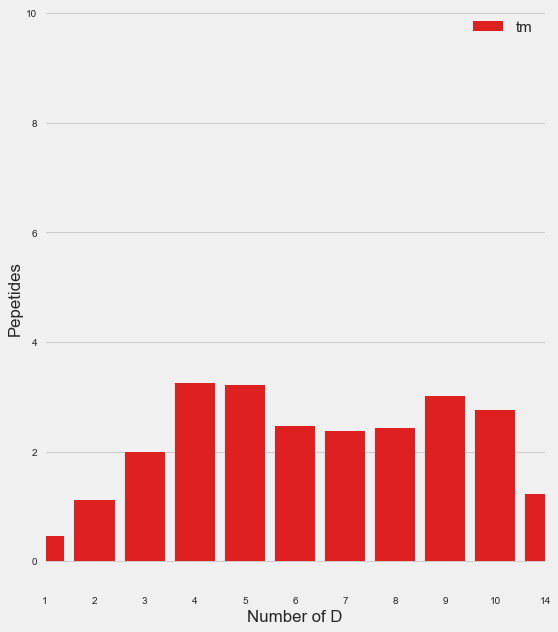

In [129]:
pep, idx1 = pl.pep_diff_sig_class(dstate=("Apo", "Binary"), st1_st2=True, er_da=1)
data = fd.loc[idx1]
#data = data.loc[data['Deut Time (sec)'] == 120]
len(data)
plt.figure(figsize =(8,10))
br = sns.barplot(y="Apo_Binary", x ="idx_pep", data =data.loc[data['Deut Time (sec)'] == 120], label = "tm", color="r", dodge =False)
br.legend(loc= "upper right", frameon=False,fontsize=15)
br.set(xlim=(0, 10),ylabel="Pepetides", xlabel = "Number of D")

#br.set_xlabel("Number of D",fontsize=15)
#locs, labels = plt.xticks()


plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
axis_label=data.peps.tolist()
ticks = len(data.pepsdmn) 
br.set_yticklabels(axis_label, rotation=90)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


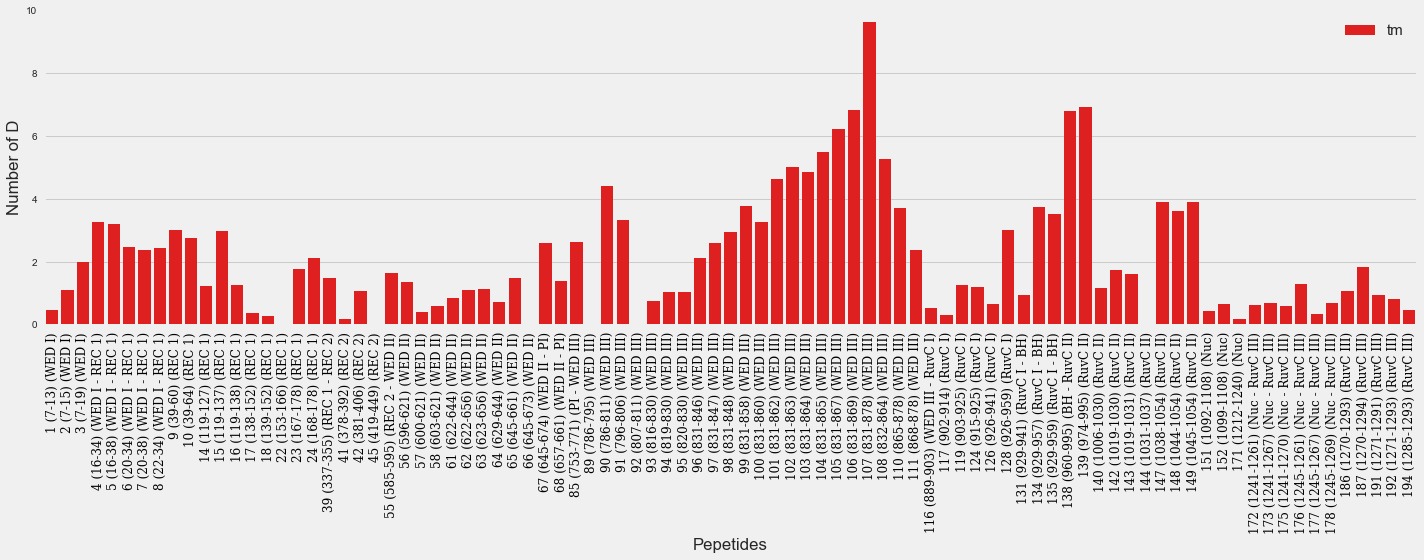

In [142]:
plot_style = 'fivethirtyeight'
data = fd.loc[idx]

data = data.loc[data['Deut Time (sec)'] == 120]
plt.figure(figsize =(20,8))
br = sns.barplot(x ="idx_pep", y="Apo_Binary", data=data, label = "tm", color="r", dodge =False)
br.legend(loc= "upper right", frameon=False,fontsize=15)
br.set(ylim=(0, 10), xlabel="Pepetides", ylabel = "Number of D")

axis_label=data.idxdmn.tolist()
ticks = len(data.idxpep) 
font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 12}
br.set_xticklabels(axis_label,rotation=90, fontdict = font, ha ="center")
plt.tight_layout()


In [171]:
dstate=("Apo", "Binary")
st1, st2 = dstate
y = st1 + "_" + st2
y
ticks = len(data.pepsdmn)
ticks

89

In [200]:
idx

['1 (7-13)',
 '2 (7-15)',
 '3 (7-19)',
 '4 (16-34)',
 '5 (16-38)',
 '6 (20-34)',
 '7 (20-38)',
 '8 (22-34)',
 '9 (39-60)',
 '10 (39-64)',
 '14 (119-127)',
 '15 (119-137)',
 '16 (119-138)',
 '17 (138-152)',
 '18 (139-152)',
 '22 (153-166)',
 '23 (167-178)',
 '24 (168-178)',
 '39 (337-355)',
 '41 (378-392)',
 '42 (381-406)',
 '45 (419-449)',
 '55 (585-595)',
 '56 (596-621)',
 '57 (600-621)',
 '58 (603-621)',
 '61 (622-644)',
 '62 (622-656)',
 '63 (623-656)',
 '64 (629-644)',
 '65 (645-661)',
 '66 (645-673)',
 '67 (645-674)',
 '68 (657-661)',
 '85 (753-771)',
 '89 (786-795)',
 '90 (786-811)',
 '91 (796-806)',
 '92 (807-811)',
 '93 (816-830)',
 '94 (819-830)',
 '95 (820-830)',
 '96 (831-846)',
 '97 (831-847)',
 '98 (831-848)',
 '99 (831-858)',
 '100 (831-860)',
 '101 (831-862)',
 '102 (831-863)',
 '103 (831-864)',
 '104 (831-865)',
 '105 (831-867)',
 '106 (831-869)',
 '107 (831-878)',
 '108 (832-864)',
 '110 (865-878)',
 '111 (868-878)',
 '116 (889-903)',
 '117 (902-914)',
 '119 (903-925)'

In [219]:

def barplots( fd, pep_idx, time_points = None, dstate=("Apo", "Binary"), plot_style = 'fivethirtyeight' ):
    """
    This function will plot D uptake for a set of peptides over time.

    """
    data = fd.loc[pep_idx]
    
    st1, st2 = dstate
    y = st1 + "_" + st2
    ystd = st1 + "_" + st2 +"_"+ "std"
    
    plt.style.use(plot_style)
    plt.figure(figsize =(18,14))

    for idx, tm in enumerate(time_points):
        plt.subplot(len(time_points),1, idx+1)
        br = sns.barplot(x ="idxdmn", y=y, data =data[data['Deut Time (sec)'] == tm], label = tm)
        br.legend(loc= "upper right", frameon=False,fontsize=15)
        br.set(ylim=(0, 10), xlabel="Pepetides", ylabel = "Number of D")

        tick_labels=data.idxdmn.tolist()
        nticks = range(len(data.idxdmn)) 
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 12}
        #br.set_xticks(nticks)
        br.set_xticklabels(tick_labels,rotation=90, fontdict = font, ha ="center")
    plt.tight_layout()





/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


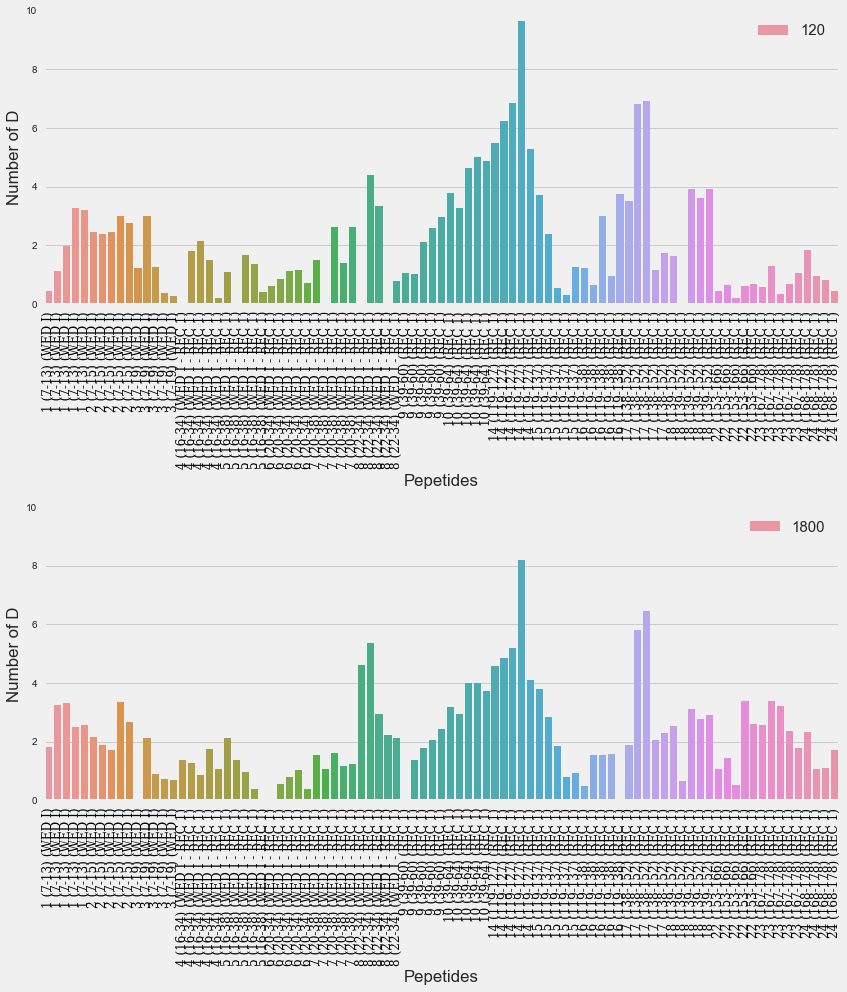

In [218]:
barplots(fd, idx, time_points =[120,1800],  dstate=("Apo", "Binary"), plot_style = 'fivethirtyeight' )

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


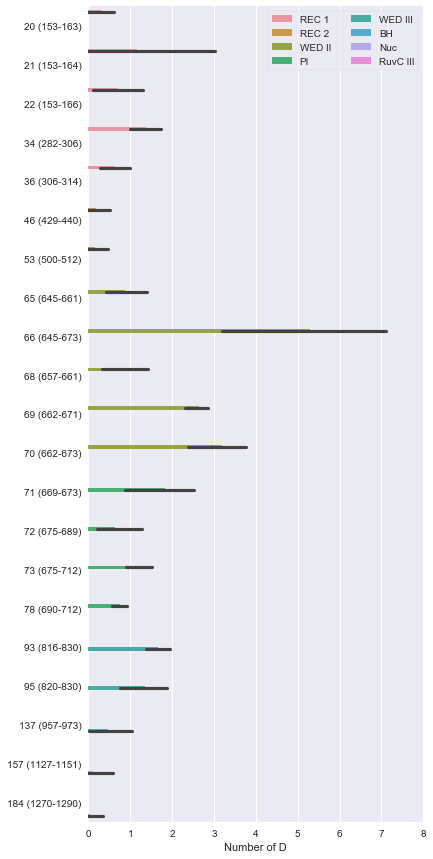

In [17]:
f, ax = plt.subplots(figsize=(6, 15))

ax = sns.barplot(
y = "idx1", x = "Binary_Ternary", hue = 'domains_start',
data =data)

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 8), ylabel="",
       xlabel="Number of D")
sns.despine(left=True, bottom=True)

In [ ]:
            #locs, labels = plt.xticks()


            #plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
        #axis_label=data.pepsdmn.unique.tolist()
        #ticks = len(data.pepsdmn.unique())  

        for i, ax in enumerate(axss):

            ax.legend(loc= "upper right", frameon=False,fontsize=15)
            ax.set(ylim=(0, 10), xlabel="")
            ax.set_ylabel("Number of D",fontsize=15)

        #locs, labels = plt.xticks()

        plt.xticks(ticks, axis_label, rotation=90, ha="right" fontsize=15)
            #plt.xls(axis_label, rotation=90, ha="right", fontsize=15)

            #sns.despine(left=True, bottom=True)

            #plt.tight_layout()
            #plt.savefig("barplot1.pdf", dpi=500, bbox_extra_artists=(ax1,ax2,ax3), bbox_inches='tight')



In [8]:
pl = plots()
data = pl.cal_diff()
pep, sig = pl.pep_diff_sig_class(dstate=('Binary', "Ternary"), st1_st2=True, er_da=0.5)
data = data.loc[sig]
#data = data.loc[data["Deut Time (sec)"] ==120]
data = data[["Deut Time (sec)","idx1","Binary_Ternary", 'domains',
       'domains_start', 'pepsdmn']]

In [9]:
pep, sig

(array(['20. FKANSDITDID (153-163) (REC 1)',
        '21. FKANSDITDIDE (153-164) (REC 1)',
        '22. FKANSDITDIDEAL (153-166) (REC 1)',
        '34. NTIIGGKFVNGENTKRKGINEYINL (282-306) (REC 1)',
        '36. LYSQQINDK (306-314) (REC 1)',
        '46. NLDNPSKKEQEL (429-440) (REC 2)',
        '53. AQISIKYQNQGKK (500-512) (REC 2)',
        '65. AIKENKGEGYKKIVYKL (645-661) (WED II)',
        '66. AIKENKGEGYKKIVYKLLPGANKMLPKVF (645-673) (WED II)',
        '68. IVYKL (657-661) (WED II - PI)',
        '69. LPGANKMLPK (662-671) (WED II - PI)',
        '70. LPGANKMLPKVF (662-673) (WED II - PI)',
        '71. LPKVF (669-673) (PI)', '72. SAKSIKFYNPSEDIL (675-689) (PI)',
        '73. SAKSIKFYNPSEDILRIRNHSTHTKNGSPQKGYEKFEF (675-712) (PI)',
        '78. RIRNHSTHTKNGSPQKGYEKFEF (690-712) (PI)',
        '93. NLQDVVYKLNGEAEL (816-830) (WED III)',
        '95. VVYKLNGEAEL (820-830) (WED III)',
        '137. LAAIEKDRDSARKDWKK (957-973) (BH - RuvC II)',
        '157. SFDYKNFGDKAAKGKWTIASFGSRL (1127-115

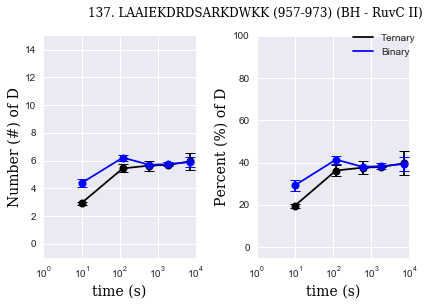

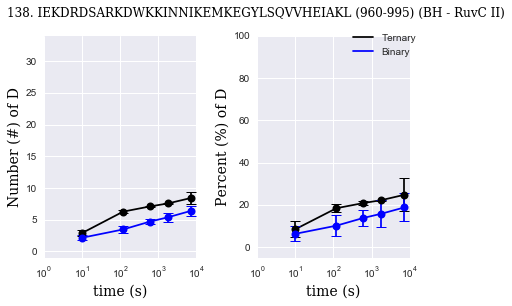

In [11]:
pl = plots()
pl.uptake_plots(plot_states = ["Ternary","Binary"],
                pep_class = None,  domains = ["BH"],
                pep_no = None,tiff = True, pdf = False)

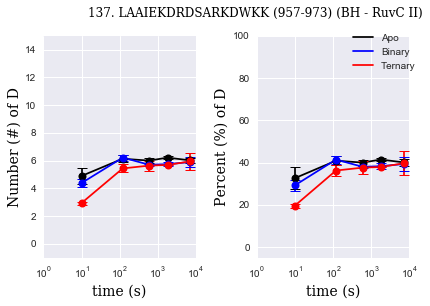

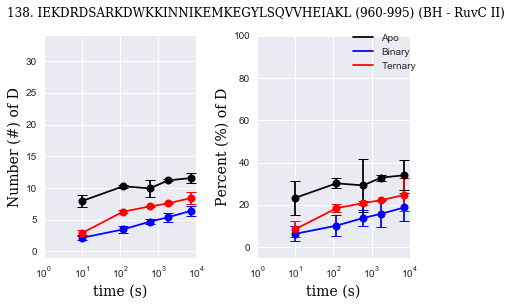

In [12]:
pl.uptake_plots(plot_states = ["Apo","Binary", "Ternary"],
                domains = ["BH"], pep_no = None,
                tiff = False, pdf = False)

In [13]:
pl.pep_map

{'BH': range(954, 972),
 'Nuc': range(1079, 1255),
 'PI': range(663, 763),
 'REC 1': range(25, 340),
 'REC 2': range(340, 592),
 'RuvC I': range(893, 954),
 'RuvC II': range(972, 1079),
 'RuvC III': range(1255, 1301),
 'WED I': range(1, 25),
 'WED II': range(592, 663),
 'WED III': range(763, 893)}

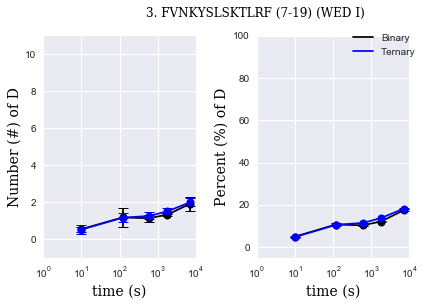

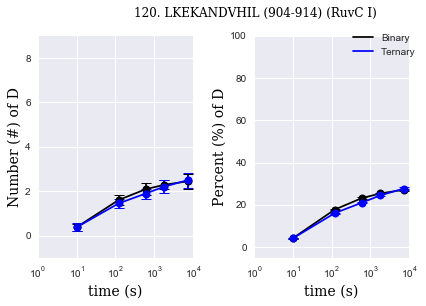

In [14]:
pl.uptake_plots(plot_states = ["Binary", "Ternary"],
                domains = None, pep_no = [3,120],
                tiff = False, pdf = False)

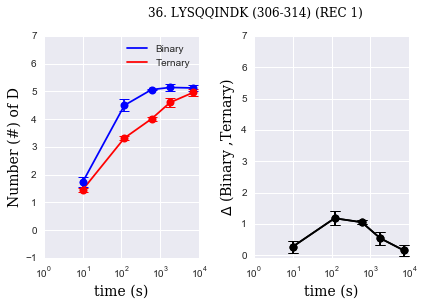

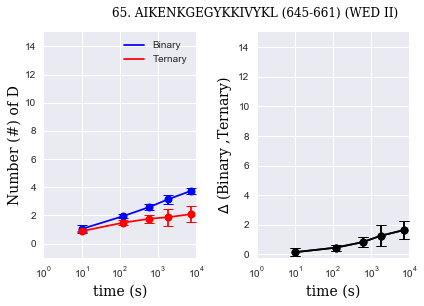

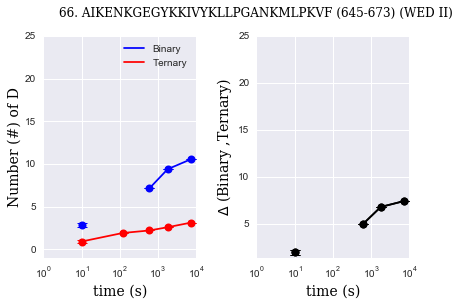

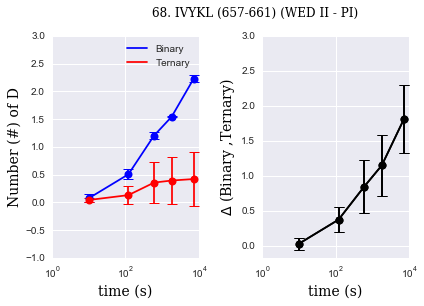

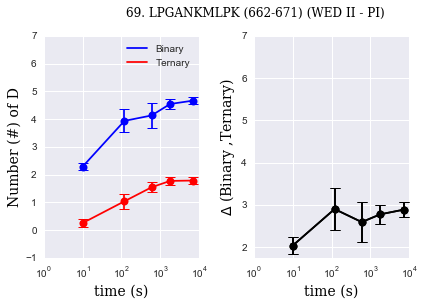

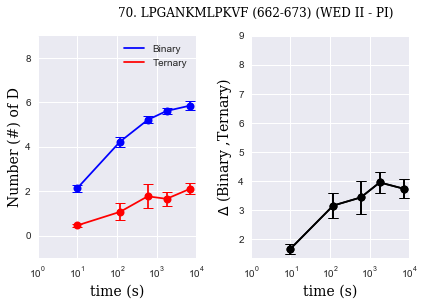

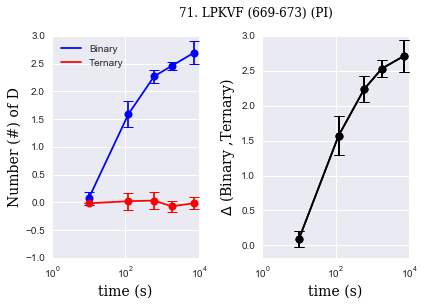

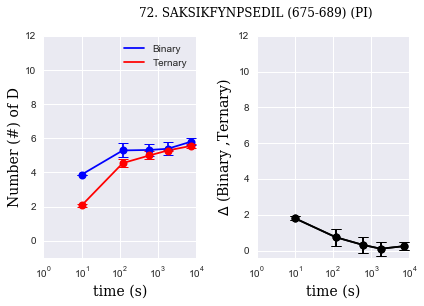

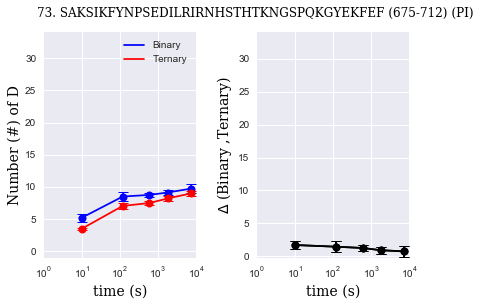

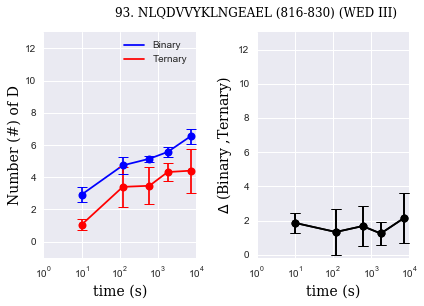

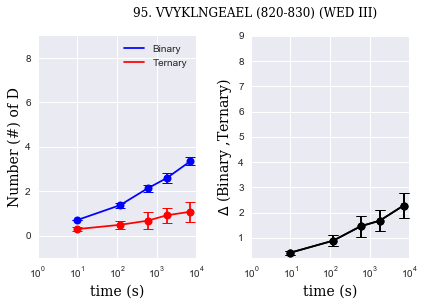

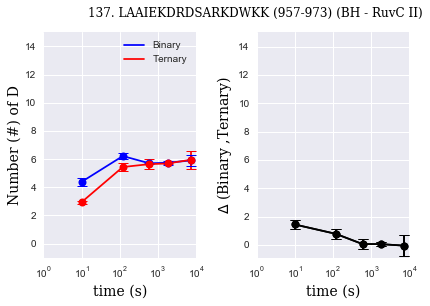

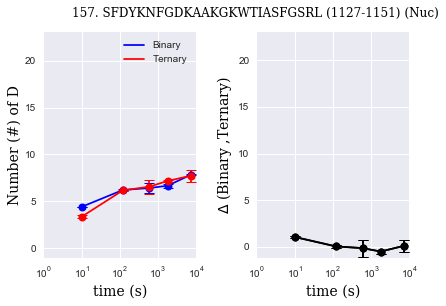

In [15]:
pep, sig_class = pl.pep_diff_sig_class(dstate=("Binary","Ternary"), st1_st2=True, er_da=1)
pl.diff_plots(diff_states = ("Binary", "Ternary"), domains = None, 
              pep_no = None , pep_class = sig_class[3:], pdf = False, tiff = False)

In [16]:
pl.cal_diff().columns

Index(['Protein State_Apo', 'Start', 'End', 'Sequence', 'Deut Time (sec)',
       'maxD', '#D_Apo', '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo',
       'Confidence_Apo', 'Stddev_Apo', 'p_Apo', 'Protein State_Binary',
       '#D_Binary', '%D_Binary', 'Conf Interval (#D)_Binary', '#Pts_Binary',
       'Confidence_Binary', 'Stddev_Binary', 'p_Binary',
       'Protein State_Ternary', '#D_Ternary', '%D_Ternary',
       'Conf Interval (#D)_Ternary', '#Pts_Ternary', 'Confidence_Ternary',
       'Stddev_Ternary', 'p_Ternary', 'idx_pep', 'idx1', 'peps', 'domains',
       'domains_start', 'pepsdmn', 'Apo_Binary', 'Apo_Ternary', 'Binary_Apo',
       'Binary_Ternary', 'Ternary_Apo', 'Ternary_Binary', 'Apo_Binary_std',
       'Apo_Ternary_std', 'Binary_Apo_std', 'Binary_Ternary_std',
       'Ternary_Apo_std', 'Ternary_Binary_std'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


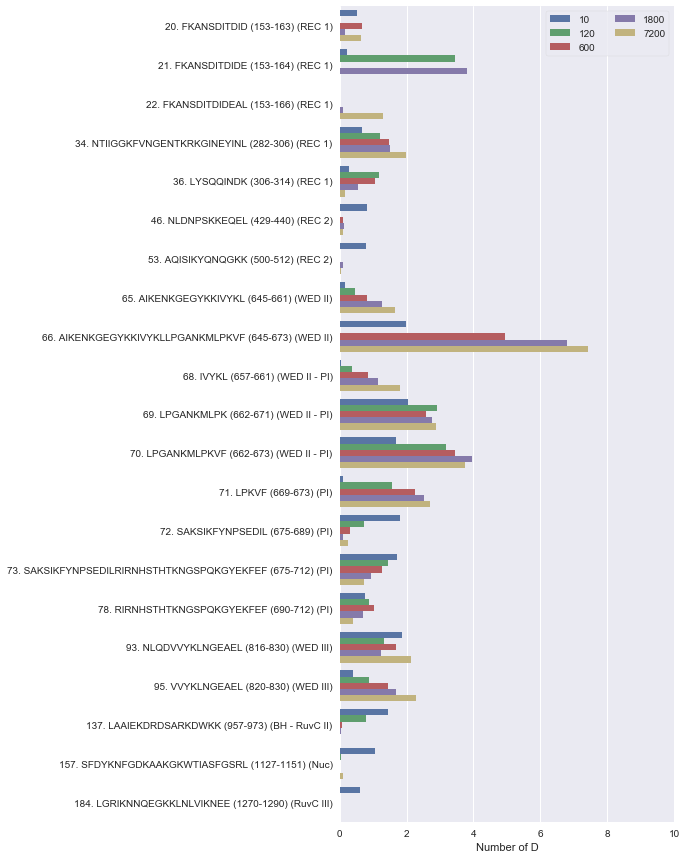

In [10]:

f, ax = plt.subplots(figsize=(6, 15))

ax = sns.barplot(y = "pepsdmn",x = "Binary_Ternary", hue='Deut Time (sec)',  data =data,)

#ax2 = sns.barplot(
#x = "peps", y = "Binary_Ternary", hue = 'domains',
#data =data.loc[data['Deut Time (sec)']==1800], ax = ax2)

#ax3 = sns.barplot(
#x = "peps", y = "Binary_Ternary", hue = 'domains',
#data =data.loc[data['Deut Time (sec)']==7200], ax = ax3)
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 10),ylabel="",
xlabel="Number of D",label = 'biger')
sns.despine(left=True, bottom=True)


#data = data.loc[data['Deut Time (sec)']==120]


In [ ]:
# Initialize the matplotlib figure
def f, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10, 10),sharex= True,sharey =True)
sns.set(style="whitegrid")

# Plot the t= 10s 
sns.set_color_codes("pastel")
ax1 = sns.barplot(y='delta(b,t)', x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==10],
             label = "10s", color="r", dodge =False, ax =ax1)
# ax1.set_xticks([])

# Plot the t= 10mins
sns.set_color_codes("muted")
ax2 = sns.barplot(y='delta(b,t)', x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==120],
            color="r", label = "10 mins", dodge =False, ax =ax2)
ax2.set_xticks([])

# Plot the t= 2 hrs
sns.set_color_codes("dark")
ax3 =sns.barplot(y='delta(b,t)',x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==7200],
             color="r", label = "2 hrs" ,dodge =False, ax = ax3)


# Add a legend and informative axis label
axis_label=df1_pos1[df1_pos1['Deut Time (sec)'] ==10].pepn_idx.tolist()

for ax in ax1,ax2,ax3:
    
    ax.legend(loc= "upper right", frameon=False,fontsize=15)
    ax.set(ylim=(0, 10), xlabel="")

for ax in ax1,ax2,ax3:
    ax.set_ylabel("Number of D",fontsize=15)

locs, labels = plt.xticks()

plt.xticks(np.arange(12), axis_label, rotation=90, fontsize=15)
plt.xls(axis_label, rotation=90, ha="right", fontsize=15)

#sns.despine(left=True, bottom=True)

#plt.tight_layout()
plt.savefig("barplot1.pdf", dpi=500, bbox_extra_artists=(ax1,ax2,ax3), bbox_inches='tight')

